# Validación y Selección

### Selección del mejor modelo entrenado en 03_ModelTraining

In [1]:
import os
import sys
# Añadir src al path para importar los scripts
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', 'src')))
#  Imports del script
from train import (
    load_and_prepare_data
)

#  Cargar y preparar datos
print("Cargando y preparando datos para LTV_180...")
X_train_ltv, y_train_ltv, X_val_ltv, y_val_ltv, X_test_ltv, y_test_ltv = load_and_prepare_data(
    path="../data/processed/final_dataset.csv",
    target="LTV_180",
    date_column="first_session"
)

print("Cargando y preparando datos para CAC_source_30...")
X_train_cac, y_train_cac, X_val_cac, y_val_cac, X_test_cac, y_test_cac = load_and_prepare_data(
    path="../data/processed/final_dataset.csv",
    target="CAC_source_30",
    date_column="first_session"
)

Cargando y preparando datos para LTV_180...
Cargando y preparando datos para CAC_source_30...


In [2]:
from IPython.display import display
import joblib
from evaluation import evaluate_all

def load_models(folder: str, target: str):
    models = {}
    for file in os.listdir(folder):
        if target in file and file.endswith(".pkl"):
            name = file.replace(f"{target}_", "").replace(".pkl", "")
            path = os.path.join(folder, file)
            models[name] = joblib.load(path)
    return models

cac_models = load_models("../models/", "CAC_source_30")
ltv_models = load_models("../models/", "LTV_180")

# 3. Evaluar modelos
print("\nEvaluación de modelos: LTV_180")
ltv_results = evaluate_all(ltv_models, X_val_ltv, y_val_ltv)
display(ltv_results.sort_values("MAPE").round(4).style.background_gradient())

print("\nEvaluación de modelos: CAC_source_30")
cac_results = evaluate_all(cac_models, X_val_cac, y_val_cac)
display(cac_results.sort_values("MAPE").round(4).style.background_gradient())



Evaluación de modelos: LTV_180


/home/pablo-herrera/Documents/USFQ/8vo/DataMining/Proyecto_final/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/pablo-herrera/Documents/USFQ/8vo/DataMining/Proyecto_final/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


,MAE,RMSE,MAPE
Model,,,
rf,0.088100,2.176000,0.172000
lgb,0.770300,16.850100,2.244200
xgb,0.165100,2.179800,2.301500
best_tscv,0.156500,2.948000,4.978900
cat,0.574900,17.218800,14.177900
ridge,3.238600,5.325200,201.171500
linear,3.240400,5.326700,201.343300
stacking,3.476300,5.183600,232.695000
sgd,36526379.097700,68432151.846200,2423252965.246400



Evaluación de modelos: CAC_source_30


/home/pablo-herrera/Documents/USFQ/8vo/DataMining/Proyecto_final/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/pablo-herrera/Documents/USFQ/8vo/DataMining/Proyecto_final/env/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


,MAE,RMSE,MAPE
Model,,,
stacking,2764.265400,3927.841200,66.357300
rf,2498.004100,3587.999700,66.738000
best_tscv,2837.095800,4046.893200,67.216300
lgb,2904.049400,4110.178600,67.482500
cat,2879.008600,4110.869700,68.038200
xgb,2733.684800,3892.321000,71.052400
linear,3590.678300,4618.769600,73.026900
ridge,3590.854200,4618.944400,73.027600
sgd,5797309.463500,7629539.212700,194700.929600


In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import joblib

In [5]:
df = pd.read_csv("../data/processed/final_dataset.csv", parse_dates=["first_session"])
df = df[df["first_session"] < "2018-07-01"]
ltv_df = df[~df["LTV_180"].isna()]   # registros con target

train_mask = ltv_df["first_session"] < "2018-01-01"             # 2017
X_train = ltv_df.loc[train_mask].drop(
            columns=['uid', 'first_session', 'last_session',
                     'first_order', 'last_order', 'LTV_180',
                     'CAC_source_30', 'ltv_cohort_avg',
                     'cac_cohort_avg', 'conversion_rate_cohort'],
            errors='ignore')
y_train = ltv_df.loc[train_mask, "LTV_180"]

In [ ]:
# Preprocesamiento + imputación + escala + OHE

num_cols = X_train.select_dtypes(include=['int', 'float']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

numeric_tf = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
])

categoric_tf = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer([
        ('num', numeric_tf, num_cols),
        ('cat', categoric_tf, cat_cols)
])

gbr = GradientBoostingRegressor(random_state=42)

full_pipe = Pipeline([
        ('preprocess', preprocess),
        ('model', gbr)
])

tscv = TimeSeriesSplit(n_splits=5)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

param_grid = {
    "model__n_estimators": [200, 300, 400],
    "model__learning_rate": [0.03, 0.05, 0.1],
    "model__max_depth": [2, 3, 4]
}

gsearch = GridSearchCV(
    estimator=full_pipe,
    param_grid=param_grid,
    cv=tscv,
    scoring=mae_scorer,
    n_jobs=-1,
    verbose=2,
    refit=True
)

# Entrenar búsqueda
gsearch.fit(X_train, y_train)

print(f"Mejor MAE (CV, negativo): {gsearch.best_score_:.4f}")
print("Mejores hiperparámetros:", gsearch.best_params_)


cv_results = pd.DataFrame(gsearch.cv_results_)
cv_results.to_csv("../data/processed/cv_results_ltv_tscv.csv", index=False)

best_ltv_model = gsearch.best_estimator_
joblib.dump(best_ltv_model, "../models/LTV_180_best_tscv.pkl")


In [15]:

df = pd.read_csv("../data/processed/final_dataset.csv", parse_dates=["first_session"])
df = df[df["first_session"] < "2018-07-01"]
  # registros con target
cac_df = df[~df["CAC_source_30"].isna()]
train_mask = cac_df["first_session"] < "2018-01-01"
          # 2017
X_train = cac_df.loc[train_mask].drop(
            columns=['uid', 'first_session', 'last_session',
                     'first_order', 'last_order', 'LTV_180',
                     'CAC_source_30', 'ltv_cohort_avg',
                     'cac_cohort_avg', 'conversion_rate_cohort'],
            errors='ignore')
y_train = cac_df.loc[train_mask, "CAC_source_30"]

In [ ]:
# Preprocesamiento + imputación + escala + OHE

num_cols = X_train.select_dtypes(include=['int', 'float']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object', 'category', 'bool']).columns.tolist()

numeric_tf = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
])

categoric_tf = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

preprocess = ColumnTransformer([
        ('num', numeric_tf, num_cols),
        ('cat', categoric_tf, cat_cols)
])

gbr = GradientBoostingRegressor(random_state=42)

full_pipe = Pipeline([
        ('preprocess', preprocess),
        ('model', gbr)
])

tscv = TimeSeriesSplit(n_splits=5)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

param_grid = {
    "model__n_estimators": [200, 300, 400],
    "model__learning_rate": [0.03, 0.05, 0.1],
    "model__max_depth": [2, 3, 4]
}

gsearch = GridSearchCV(
    estimator=full_pipe,
    param_grid=param_grid,
    cv=tscv,
    scoring=mae_scorer,
    n_jobs=-1,
    verbose=2,
    refit=True
)

# Entrenar búsqueda
gsearch.fit(X_train, y_train)

print(f"Mejor MAE (CV, negativo): {gsearch.best_score_:.4f}")
print("Mejores hiperparámetros:", gsearch.best_params_)


cv_results = pd.DataFrame(gsearch.cv_results_)
cv_results.to_csv("../data/processed/cv_results_cac_tscv.csv", index=False)

best_cac_model = gsearch.best_estimator_
joblib.dump(best_cac_model, "../models/CAC_source_30_best_tscv.pkl")


# Explicabilidad y Diagnostico

### LTV

In [6]:
# 1. Cargar dataset y test sets para ambos targets
df = pd.read_csv("../data/processed/final_dataset.csv", parse_dates=["first_session"])
df = df[df["first_session"] < "2018-07-01"]

## -------- LTV
ltv_df = df[~df["LTV_180"].isna()]
ltv_test = ltv_df[(ltv_df["first_session"] >= "2018-01-01") & (ltv_df["first_session"] < "2018-07-01")]

ltv_X = ltv_test.drop(columns=['uid', 'first_session', 'last_session', 'first_order', 'last_order',
                               'LTV_180', 'CAC_source_30', 'ltv_cohort_avg', 'cac_cohort_avg', 'conversion_rate_cohort'],
                     errors='ignore')
ltv_y = ltv_test["LTV_180"]

In [7]:

best_ltv_model = joblib.load("../models/LTV_180_best_tscv.pkl")

# Dataset ya cargado antes  ltv_test, ltv_X, ltv_y
assert "ltv_X" in globals(), "Ejecuta primero la celda del Paso 1 para definir ltv_X"

# Obtener nombres de features después del ColumnTransformer
feature_names = best_ltv_model.named_steps["preprocess"].get_feature_names_out()


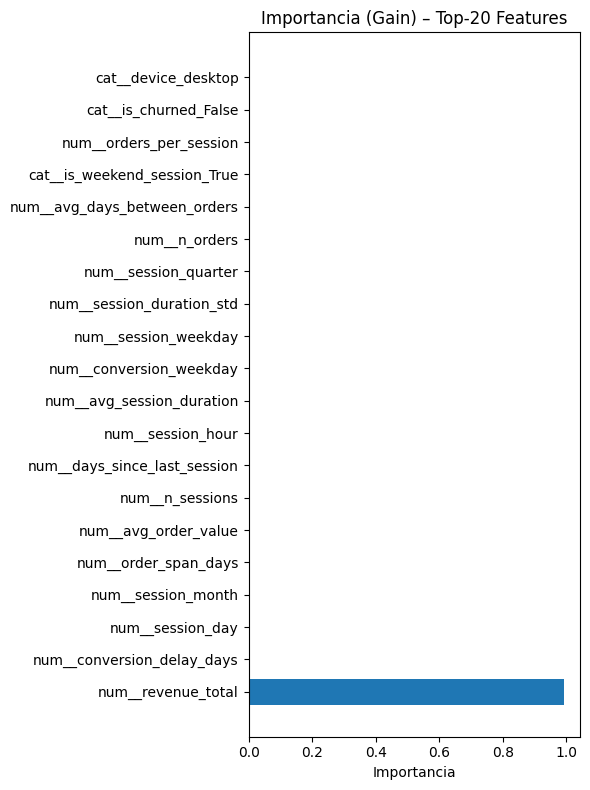

In [18]:
importances = best_ltv_model.named_steps["model"].feature_importances_
idx_sorted  = np.argsort(importances)[::-1][:20]          # top‑20

plt.figure(figsize=(6, 8))
plt.barh(range(len(idx_sorted))[::-1], importances[idx_sorted])
plt.yticks(range(len(idx_sorted))[::-1], feature_names[idx_sorted])
plt.title("Importancia (Gain) – Top‑20 Features")
plt.xlabel("Importancia")
plt.tight_layout()
plt.gca().invert_yaxis()
plt.savefig("../reports/figures/ltv_gain_importance_top20.png")

Analizando la importancia de features en nuestro modelo predictivo de LTV para Showz, se evidencia que "num_revenue_total" domina claramente con un valor cercano a 1.0, mientras que las demás variables (patrones temporales de sesión, frecuencia de compra y comportamiento de navegación) muestran una contribución prácticamente insignificante en comparación. Este resultado sugiere que nuestro modelo XGBoost está basando sus predicciones casi exclusivamente en el historial de ingresos del cliente, lo cual señala una clara oportunidad para mejorar nuestro feature engineering mediante características más sofisticadas o transformaciones que equilibren la influencia predictiva y capturen dimensiones adicionales del comportamiento del usuario que podrían enriquecer significativamente la capacidad predictiva del modelo de LTV a 6-12 meses.

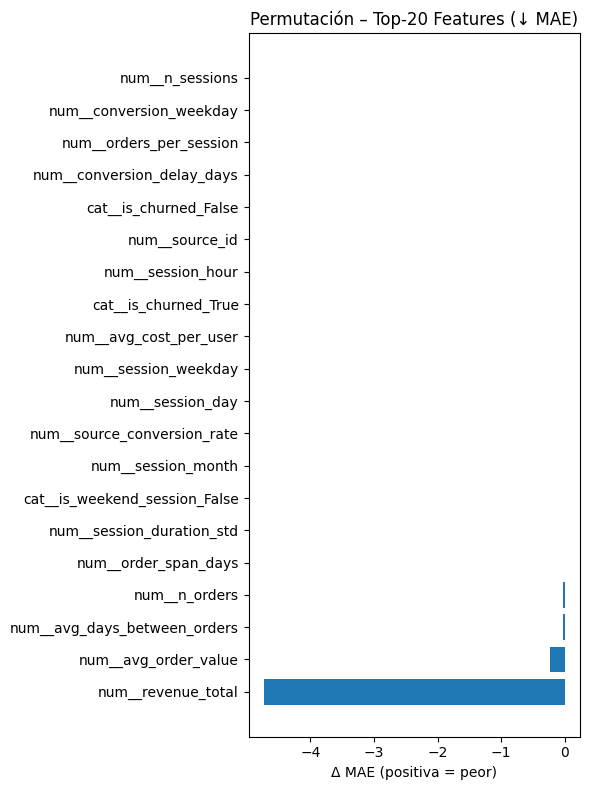

In [20]:
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_absolute_error, make_scorer

perm = permutation_importance(
    best_ltv_model, ltv_X, ltv_y,
    n_repeats=10,
    scoring=make_scorer(mean_absolute_error, greater_is_better=False),
    n_jobs=-1,
    random_state=42
)

idx_perm = np.argsort(perm.importances_mean)[::-1][:20]

plt.figure(figsize=(6, 8))
plt.barh(range(len(idx_perm))[::-1], -perm.importances_mean[idx_perm])  # neg → pos
plt.yticks(range(len(idx_perm))[::-1], feature_names[idx_perm])
plt.title("Permutación – Top‑20 Features (↓ MAE)")
plt.xlabel("Δ MAE (positiva = peor)")
plt.tight_layout()
plt.gca().invert_yaxis()
plt.savefig("../reports/figures/ltv_permutation_importance_top20.png")

El análisis de importancia por permutación revela una perspectiva complementaria sobre nuestras variables predictivas de LTV, donde "num_revenue_total" confirma su rol crítico al mostrar el mayor impacto negativo en el rendimiento del modelo cuando es aleatorizada (Δ MAE aproximadamente -4.5). Siguiendo en importancia, aunque con una diferencia considerable, aparecen "num_avg_order_value" y "num_avg_days_between_orders", variables que reflejan el comportamiento de compra del cliente. Este método de evaluación, al medir directamente el impacto en el error cuando cada característica es permutada, proporciona evidencia más robusta que el gain de importancia anterior, sugiriendo que si bien el ingreso histórico sigue siendo dominante, variables relacionadas con el valor promedio de pedidos y la frecuencia de compra también contribuyen significativamente a la precisión de nuestras predicciones de LTV, lo que ofrece una dirección más clara para optimizar tanto nuestro feature engineering como las estrategias de negocio orientadas a maximizar el valor del cliente.

<Figure size 640x480 with 0 Axes>

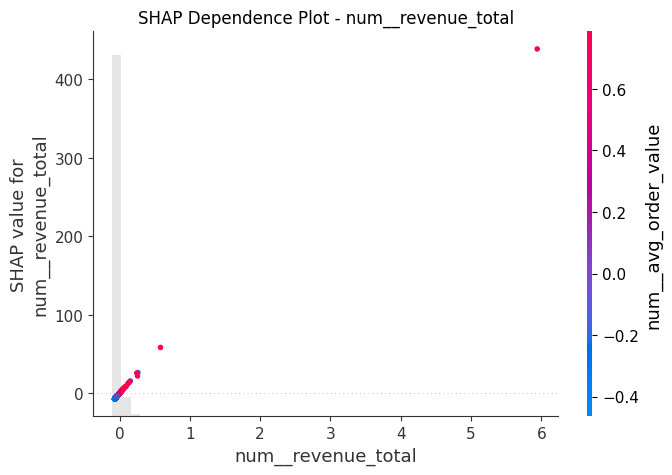

<Figure size 640x480 with 0 Axes>

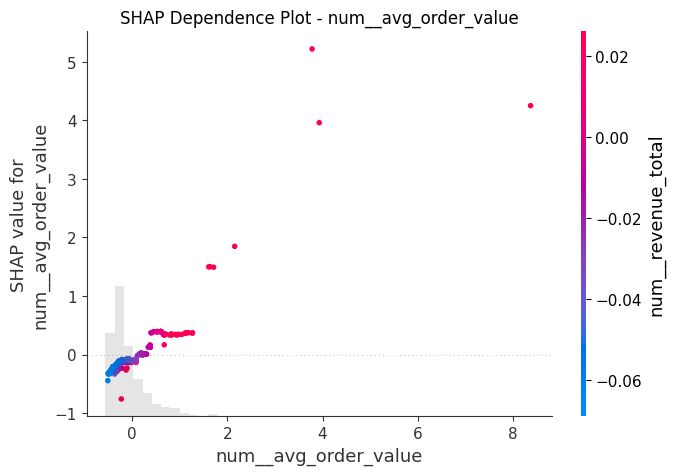

<Figure size 640x480 with 0 Axes>

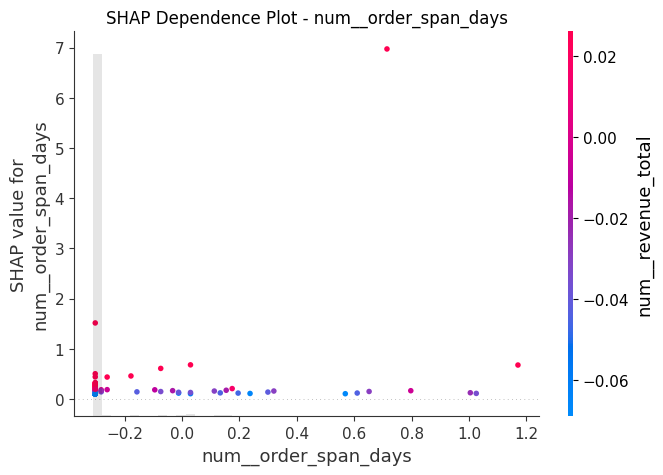

<Figure size 640x480 with 0 Axes>

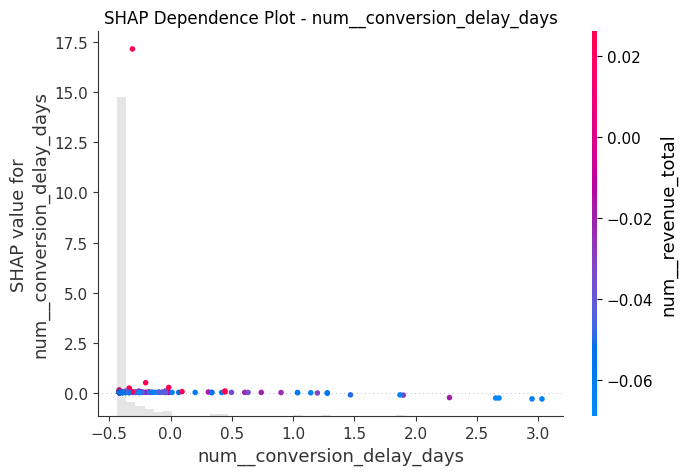

<Figure size 640x480 with 0 Axes>

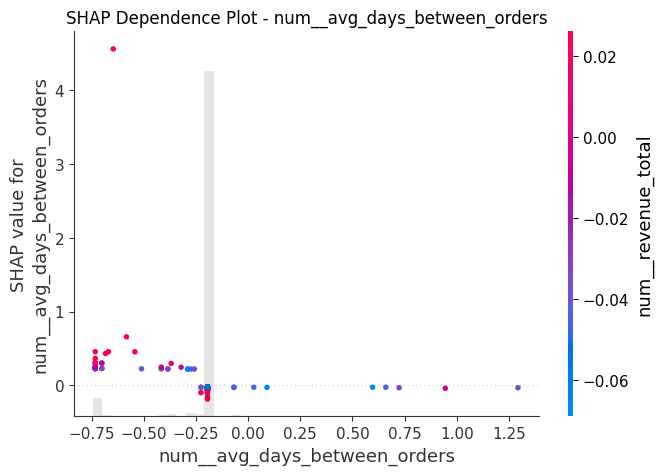

In [13]:

import shap

# Separar pasos del Pipeline
preprocess   = best_ltv_model.named_steps["preprocess"]
inner_model  = best_ltv_model.named_steps["model"]  # GradientBoostingRegressor

# Tomar muestra para explicación (500 obs ≈ rápido y estable)
X_sample_raw = ltv_X.sample(n=500, random_state=42)

# Transformar la muestra → matriz numérica
X_sample_num = preprocess.transform(X_sample_raw)

# Obtener nombres de columnas después de OHE/escala
feature_names = preprocess.get_feature_names_out()

# Convertir a DataFrame para que los gráficos muestren etiquetas
X_sample_num_df = pd.DataFrame(X_sample_num, columns=feature_names)

# Crear TreeExplainer (optimizado para modelos de árbol)
explainer   = shap.TreeExplainer(inner_model)
shap_values = explainer(X_sample_num_df)

# Plot global (beeswarm)
plt.figure()
shap.plots.beeswarm(shap_values, max_display=20, show=False)
plt.title("SHAP Beeswarm Plot - Top 20 Features")
plt.savefig("../reports/figures/shap_beeswarm_top20.png", bbox_inches="tight")
plt.close()

# Plots de dependencia para las 5 variables más influyentes
top_idx = np.argsort(np.abs(shap_values.values).mean(0))[::-1][:5]
for i in top_idx:
    feature_name = feature_names[i]
    plt.figure()
    shap.plots.scatter(
        shap_values[:, i],
        color=shap_values,
        show=False
    )
    plt.title(f"SHAP Dependence Plot - {feature_name}")
    plt.savefig(f"../reports/figures/shap_dependence_{feature_name}.png", bbox_inches="tight")
    plt.show()



El análisis del gráfico SHAP Dependence Plot para "num_revenue_total" revela una relación fuertemente positiva y no lineal con el LTV predicho. Observamos que a medida que el ingreso histórico total aumenta, su impacto en la predicción del valor del cliente crece de manera exponencial, con un punto de inflexión notable alrededor del valor 1, donde la pendiente se intensifica significativamente. Los puntos están coloreados según el valor de "num_avg_order_value", mostrando una correlación donde clientes con mayor valor promedio de pedido (tonos más rojizos) tienden a generar valores SHAP más altos para ingresos similares. Esta visualización confirma que nuestro modelo identifica un efecto multiplicador: no solo importa cuánto ha gastado un cliente históricamente, sino que este comportamiento se potencia cuando además realiza compras de mayor valor unitario, lo que sugiere oportunidades de segmentación para estrategias de up-selling enfocadas en aumentar el valor promedio de pedido como palanca para maximizar el LTV.

El gráfico SHAP Dependence Plot para "num_avg_order_value" revela una relación positiva con la predicción de LTV, aunque con un comportamiento más complejo que el observado con el ingreso total. La contribución de esta variable al valor predicho aumenta de manera no uniforme, con un crecimiento moderado hasta aproximadamente el valor 1, seguido de casos puntuales de alto impacto para valores más elevados. La distribución de puntos muestra una concentración significativa de observaciones en valores bajos (histograma lateral), pero con casos aislados de valores extremos que generan contribuciones SHAP desproporcionadamente altas. La coloración según "num_revenue_total" indica que clientes con valores promedio de pedido similares tienen impactos distintos dependiendo de su historial de ingresos totales, reforzando la interacción entre ambas variables. Este análisis sugiere que identificar y potenciar clientes con potencial de realizar compras de mayor valor unitario podría ser una estrategia efectiva para incrementar el LTV, especialmente cuando se combina con acciones para aumentar la frecuencia de compra.

El gráfico SHAP Dependence Plot para "num_order_span_days" muestra un patrón interesante donde la mayoría de los valores se concentran en la parte inferior izquierda, con valores SHAP cercanos a cero o ligeramente positivos. La distribución del histograma lateral indica una fuerte concentración de observaciones en valores negativos o muy cercanos a cero, sugiriendo que esta variable tiene una distribución sesgada en nuestra población. Se observan algunos puntos aislados con contribuciones SHAP significativamente más altas, particularmente un valor extremo cercano a 7, lo que indica casos específicos donde el período entre la primera y última compra tiene un impacto desproporcionadamente alto en la predicción de LTV. La coloración según "num_revenue_total" no muestra un patrón claramente definido, lo que sugiere que la influencia de esta variable es relativamente independiente del ingreso total del cliente. Este comportamiento indica que el modelo ha capturado ciertos patrones de compra longitudinales como predictores de valor futuro, especialmente en segmentos específicos de clientes, aunque su influencia general es menos sistemática que las variables anteriormente analizadas.

El gráfico SHAP Dependence Plot para "num_conversion_delay_days" presenta una distribución donde la mayoría de los valores tienen un impacto SHAP cercano a cero, independientemente del valor de la variable. La concentración en el histograma lateral muestra que la mayoría de las observaciones se sitúan en valores negativos o cercanos a cero, indicando que muchos usuarios convierten rápidamente tras su primera interacción. Destaca un único punto extremo con un valor SHAP cercano a 17.5, que representa un caso atípico donde el retraso en la conversión tuvo una influencia excepcionalmente alta en la predicción de LTV. La coloración según "num_revenue_total" no muestra un patrón definido, sugiriendo que el tiempo de conversión opera de manera independiente al ingreso total histórico. Esta variable parece tener un comportamiento principalmente neutral para la mayoría de los clientes, con excepciones puntuales donde tiempos de conversión específicos pueden señalizar comportamientos de alto valor futuro. Para efectos prácticos del modelo, esta característica aporta información relevante solo para segmentos muy específicos de clientes.

El gráfico SHAP Dependence Plot para "num_avg_days_between_orders" revela un comportamiento interesante donde la mayor contribución al LTV proviene de valores negativos de esta variable. El histograma lateral muestra una distribución bimodal, con concentraciones significativas en valores negativos (alrededor de -0.5) y en cero, mientras que hay una presencia menor de valores positivos. Se observa un valor SHAP particularmente alto (cercano a 4.5) para un caso específico con un valor negativo de la variable, sugiriendo que ciertos patrones de frecuencia de compra tienen un impacto desproporcionado en el LTV predicho. La coloración según "num_revenue_total" muestra cierta tendencia donde los puntos con valores SHAP más altos corresponden a tonos más rojizos (mayores ingresos totales), aunque esta relación no es completamente consistente. Este análisis sugiere que los intervalos entre pedidos funcionan como un indicador importante de compromiso del cliente, donde valores negativos (posiblemente indicando compras agrupadas o frecuentes) tienen una asociación positiva con el valor futuro del cliente, lo que proporciona insights valiosos para estrategias de retención y activación.

In [30]:
ltv_test = ltv_test.copy()
ltv_test["pred"]   = best_ltv_model.predict(ltv_X)
ltv_test["absErr"] = np.abs(ltv_test["pred"] - ltv_test["LTV_180"])

segment_cols = ["device", "source", "country"]          # ⟵ las que te interesen
segment_cols = [c for c in segment_cols if c in ltv_test.columns]  # filtra disponibles

for col in segment_cols:
    seg = (
        ltv_test.groupby(col)["absErr"]
                .mean()
                .sort_values(ascending=False)
                .to_frame("MAE_segmento")
                .head(10)
    )
    print(f"\n--- MAE por {col} ---")
    display(seg)



--- MAE por device ---


,MAE_segmento
device,
desktop,0.204212
touch,0.121920


Los resultados para la segmentación por device indican que el Error Absoluto Medio (MAE) es mayor para los usuarios de desktop (MAE = 0.2042) en comparación con los usuarios de dispositivos touch (MAE = 0.1219). Esto sugiere que el modelo, si bien puede tener un buen rendimiento general, es ligeramente menos preciso al predecir el LTV para los usuarios que interactúan con Showz a través de la plataforma de escritorio. Esta diferencia, aunque no drástica, podría investigarse más a fondo para entender sus causas, como por ejemplo, si los patrones de comportamiento o gasto difieren significativamente entre estos dos grupos de dispositivos de una manera que el modelo actual no captura completamente.

### CAC

In [16]:

# Cargar modelo óptimo
best_cac_model = joblib.load("../models/CAC_source_30_best_tscv.pkl")

# Crear set de prueba (H1‑2018) si no existe en memoria
cac_test = cac_df[(cac_df["first_session"] >= "2018-01-01") &
                  (cac_df["first_session"] <  "2018-07-01")]

cac_X = cac_test.drop(
            columns=['uid', 'first_session', 'last_session',
                     'first_order', 'last_order', 'LTV_180',
                     'CAC_source_30', 'ltv_cohort_avg',
                     'cac_cohort_avg', 'conversion_rate_cohort'],
            errors='ignore')
cac_y = cac_test["CAC_source_30"]


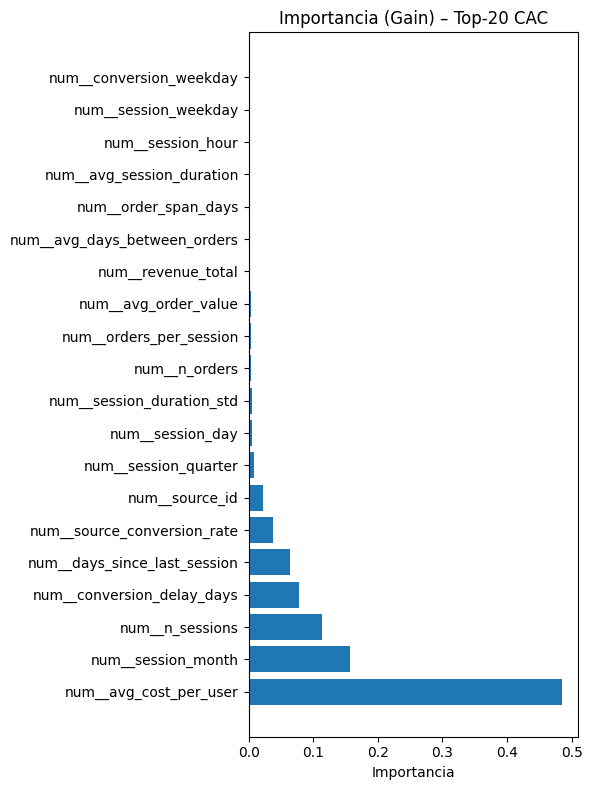

In [24]:
# Importancia de variables (gain)
feature_names = best_cac_model.named_steps["preprocess"].get_feature_names_out()
gain = best_cac_model.named_steps["model"].feature_importances_
idx = np.argsort(gain)[::-1][:20]

plt.figure(figsize=(6, 8))
plt.barh(range(len(idx))[::-1], gain[idx])
plt.yticks(range(len(idx))[::-1], feature_names[idx])
plt.title("Importancia (Gain) – Top‑20 CAC")
plt.xlabel("Importancia")
plt.tight_layout()
plt.gca().invert_yaxis()

# Guardar figura
plt.savefig("../reports/figures/cac_gain_importance_top20.png", bbox_inches="tight")

Para comprender qué factores son los más influyentes en las predicciones de nuestro modelo de Costo de Adquisición de Clientes (CAC), analizamos la importancia de las variables utilizando el método de 'gain' (ganancia) proporcionado por el modelo GradientBoostingRegressor. Este método cuantifica la contribución relativa de cada característica a la reducción del error durante el entrenamiento del modelo. La visualización resultante muestra las 20 principales características ordenadas por su importancia, donde num__avg_cost_per_user destaca significativamente como el predictor más potente, con una importancia cercana al 0.5. Le siguen, con una contribución considerablemente menor, variables como num__session_month y num__n_sessions. Este análisis inicial sugiere que el costo promedio histórico por usuario es el principal impulsor de las predicciones del CAC, mientras que otras características relacionadas con la temporalidad de las sesiones y el número de sesiones también aportan información relevante, aunque en menor medida.

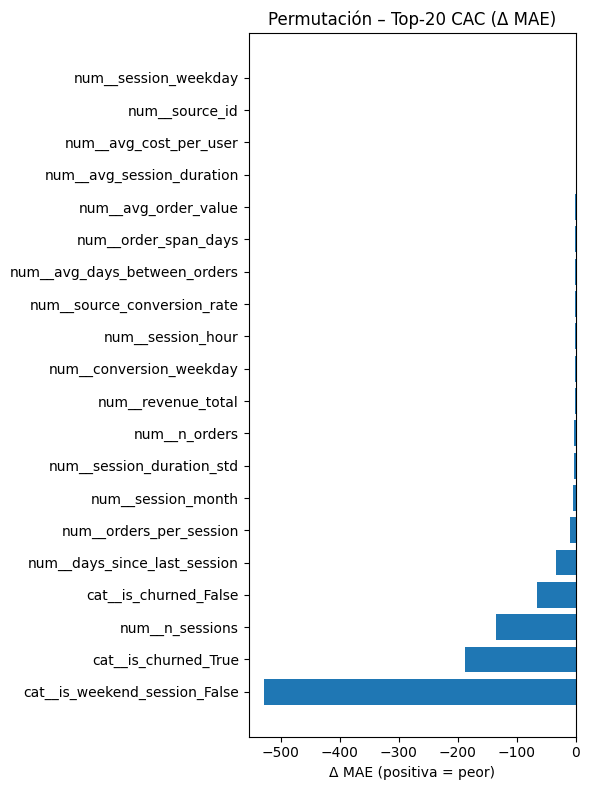

In [23]:
# Importancia de permutación
perm = permutation_importance(
    best_cac_model, cac_X, cac_y,
    n_repeats=10,
    scoring=make_scorer(mean_absolute_error, greater_is_better=False),
    n_jobs=-1, random_state=42
)

idxp = np.argsort(perm.importances_mean)[::-1][:20]

plt.figure(figsize=(6, 8))
plt.barh(range(len(idxp))[::-1], -perm.importances_mean[idxp])
plt.yticks(range(len(idxp))[::-1], feature_names[idxp])
plt.title("Permutación – Top‑20 CAC (Δ MAE)")
plt.xlabel("Δ MAE (positiva = peor)")
plt.tight_layout()
plt.gca().invert_yaxis()

# Guardar figura
plt.savefig("../reports/figures/cac_permutation_importance_top20.png", bbox_inches="tight")

Complementando el análisis de 'gain', evaluamos la importancia de las variables para el modelo de CAC mediante la técnica de permutación en el conjunto de prueba. Este método mide el impacto en el Error Absoluto Medio (MAE) del modelo cuando los valores de una característica específica son aleatoriamente mezclados (permutados), rompiendo así su relación con la variable objetivo. Un mayor incremento en el MAE (representado como un valor negativo más grande en el gráfico, ya que usamos greater_is_better=False) indica una mayor importancia de la variable. Los resultados revelan que la característica cat__is_weekend_session_False es, con diferencia, la más influyente, ya que su permutación resulta en el mayor deterioro del rendimiento del modelo (Δ MAE ≈ -500). Le siguen variables categóricas como cat__is_churned_True y num__n_sessions. Curiosamente, este método resalta un conjunto diferente de variables clave en comparación con el 'gain', enfatizando el impacto directo en el rendimiento predictivo y sugiriendo que la distinción entre sesiones de fin de semana y entre semana, así como el estado de abandono del usuario, son cruciales para la precisión de las estimaciones del CAC.

<Figure size 640x480 with 0 Axes>

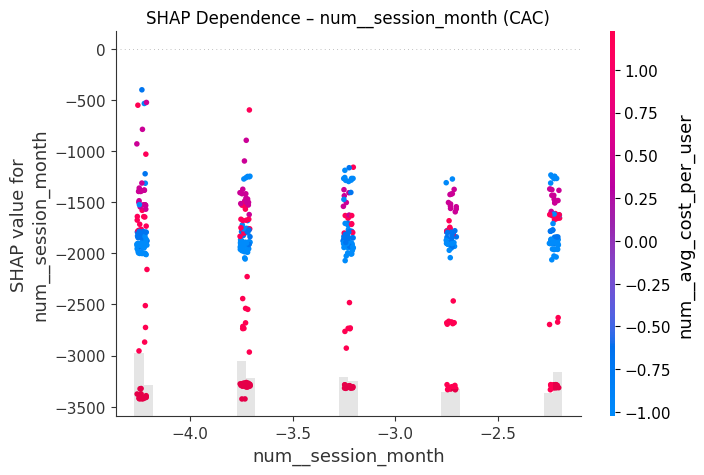

<Figure size 640x480 with 0 Axes>

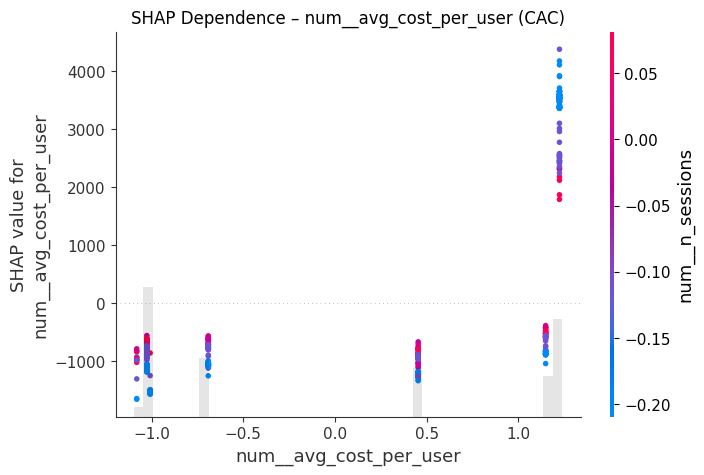

<Figure size 640x480 with 0 Axes>

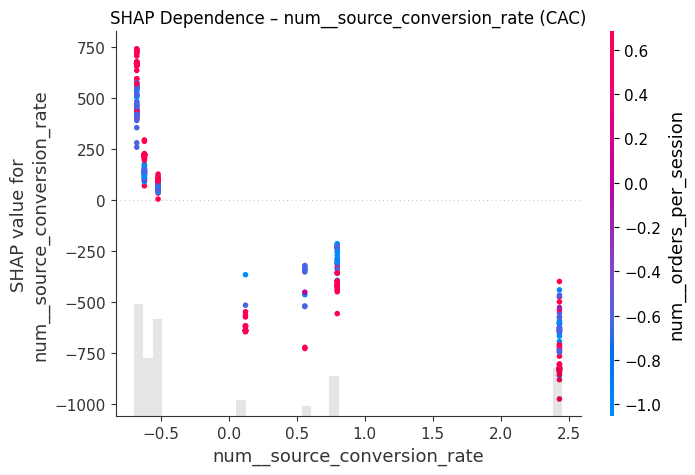

<Figure size 640x480 with 0 Axes>

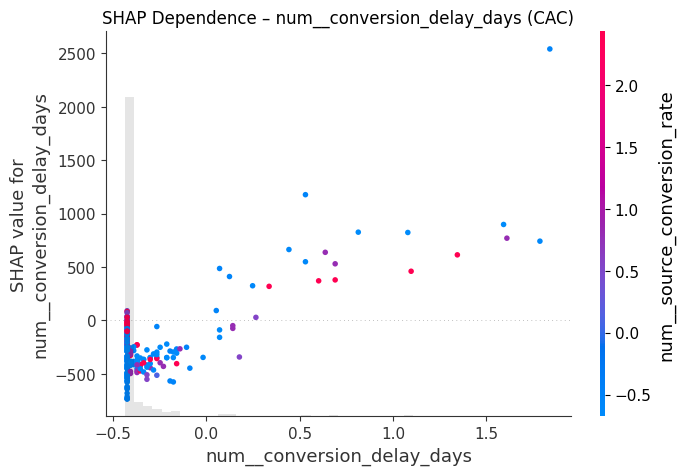

<Figure size 640x480 with 0 Axes>

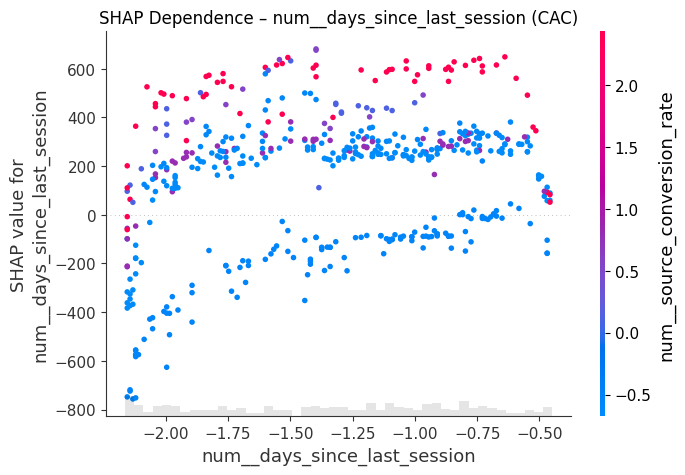

In [22]:
# Separar pasos
pre_cac  = best_cac_model.named_steps["preprocess"]
mod_cac  = best_cac_model.named_steps["model"]

# Muestra
X_sample_raw = cac_X.sample(n=500, random_state=42)
X_sample_num = pre_cac.transform(X_sample_raw)
feat_names   = pre_cac.get_feature_names_out()
X_sample_df  = pd.DataFrame(X_sample_num, columns=feat_names)

# SHAP
explainer = shap.TreeExplainer(mod_cac)
shap_vals = explainer(X_sample_df)

# Plot beeswarm
plt.figure()
shap.plots.beeswarm(shap_vals, max_display=20, show=False)
plt.title("SHAP Beeswarm – Top 20 CAC")
plt.savefig("../reports/figures/cac_shap_beeswarm_top20.png", bbox_inches="tight")
plt.close()

# Plot de dependencia para las 5 más influyentes
top_idx = np.argsort(np.abs(shap_vals.values).mean(0))[::-1][:5]
for i in top_idx:
    feature_name = feat_names[i]
    plt.figure()
    shap.plots.scatter(shap_vals[:, i], color=shap_vals, show=False)
    plt.title(f"SHAP Dependence – {feature_name} (CAC)")
    plt.savefig(f"../reports/figures/cac_shap_dependence_{feature_name}.png", bbox_inches="tight")
    plt.show()

Para profundizar en cómo las variables individuales afectan las predicciones del CAC a nivel de cada instancia, utilizamos los valores SHAP (SHapley Additive exPlanations). El gráfico de dependencia para num__session_month (mes de la sesión, probablemente transformado o escalado, dado los valores negativos en el eje x) muestra la relación entre el valor de esta característica y su impacto en la predicción del CAC. Observamos que valores más altos de num__session_month (que podrían corresponder a meses más recientes si el escalado invierte el orden, o simplemente a ciertos meses específicos dependiendo de la codificación) tienden a asociarse con valores SHAP más negativos, lo cual indica una contribución a disminuir el CAC predicho. Los puntos están coloreados según el valor de num__avg_cost_per_user; los puntos rojos representan un alto costo promedio por usuario y los azules uno bajo. Aunque no se observa una interacción extremadamente fuerte, parece que para valores similares de num__session_month, los usuarios con un costo promedio histórico más bajo (puntos azules) tienden a tener valores SHAP ligeramente menos negativos (contribuyendo menos a la reducción del CAC o incluso aumentándolo) en comparación con usuarios de alto costo promedio. La distribución vertical de los puntos en cada valor del mes de sesión sugiere que, si bien hay una tendencia general, el impacto específico puede variar considerablemente para diferentes usuarios, influenciado por otras características.

El gráfico de dependencia SHAP para num__avg_cost_per_user (costo promedio por usuario, probablemente escalado) ilustra una relación compleja y significativa con la predicción del CAC. Se observa una tendencia general donde valores más altos de num__avg_cost_per_user (hacia la derecha del eje horizontal, por ejemplo, > 1.0) están asociados con valores SHAP marcadamente positivos, indicando una fuerte contribución a aumentar el CAC predicho, como es de esperar. Inversamente, valores más bajos de num__avg_cost_per_user (por ejemplo, alrededor de -1.0) tienden a generar valores SHAP negativos, empujando la predicción del CAC hacia abajo. La característica más llamativa es la dispersión vertical de los puntos, especialmente para los valores más altos de num__avg_cost_per_user, donde algunos puntos alcanzan valores SHAP de hasta 4000. Los puntos están coloreados por num__n_sessions; los puntos azules representan un menor número de sesiones (valores más negativos en la escala de color) y los rojos/morados un mayor número. Se puede apreciar que para un alto num__avg_cost_per_user (por ejemplo, >1.0), los usuarios con un menor número de sesiones (puntos azules) tienden a tener valores SHAP más altos, lo que sugiere que un alto costo promedio por usuario combinado con pocas sesiones es un fuerte indicador de un CAC elevado. Esta interacción resalta cómo el modelo no solo considera el costo promedio, sino también el nivel de actividad del usuario para refinar sus predicciones de CAC.

El gráfico de dependencia SHAP para 'num_source_conversion_rate' muestra una relación no lineal con el CAC, donde tasas de conversión bajas tienden a aumentar el CAC predicho (valores SHAP positivos), mientras que tasas más altas lo disminuyen (valores SHAP negativos); sin embargo, la dispersión vertical indica una variabilidad considerable en este impacto entre instancias, posiblemente modulada por el 'num_orders_per_session' como sugiere la coloración de los puntos, lo que amerita una investigación más profunda para comprender la interacción entre estas variables en la predicción del costo de adquisición.

El gráfico de dependencia SHAP para 'num__conversion_delay_days' revela una tendencia donde un mayor número de días transcurridos entre la primera sesión y la conversión se asocia generalmente con valores SHAP más positivos, indicando una contribución al aumento del CAC predicho. Esta relación sugiere que los clientes que tardan más en convertir tienden a ser más costosos de adquirir. No obstante, la dispersión vertical de los puntos muestra que para un mismo número de días de retraso, el impacto en el CAC puede variar considerablemente. Los puntos están coloreados por 'num__source_conversion_rate', donde tonos azules representan tasas de conversión de la fuente más bajas y tonos rojos/rosados tasas más altas. Se observa una posible interacción, ya que para retrasos de conversión similares, las fuentes con tasas de conversión más bajas (puntos azules) parecen tener, en promedio, valores SHAP ligeramente más altos, lo que implicaría un mayor impacto en el aumento del CAC. Esta observación sugiere que un largo retraso en la conversión, combinado con una baja tasa de conversión de la fuente, podría ser un fuerte indicador de un CAC elevado.

El gráfico de dependencia SHAP para 'num__days_since_last_session' revela una relación compleja con el CAC. En general, se observa que a medida que aumenta el número de días desde la última sesión (hacia la derecha del eje x), los valores SHAP tienden a volverse más positivos, sugiriendo una mayor contribución al aumento del CAC predicho. Esto podría indicar que los usuarios que han estado inactivos durante más tiempo son más costosos de reactivar o adquirir como clientes. Sin embargo, la relación no es estrictamente lineal, y se aprecia una variabilidad considerable para valores similares de días desde la última sesión. Los puntos están coloreados por 'num__source_conversion_rate', donde los tonos azules representan tasas de conversión de la fuente más bajas y los tonos rojos/rosados tasas más altas. Parece haber una interacción sutil, donde para un mayor número de días de inactividad, las fuentes con tasas de conversión más altas (puntos rojos/rosados) tienden a tener valores SHAP ligeramente más bajos en comparación con las fuentes de menor conversión (puntos azules), lo que podría sugerir que una fuente de alta conversión mitiga parcialmente el aumento del CAC asociado con la inactividad del usuario. La dispersión vertical significativa enfatiza que otros factores también influyen en el CAC para usuarios con un número similar de días desde su última sesión.

In [35]:
# Analisis por segmento

cac_test = cac_test.copy()
cac_test["pred"]   = best_cac_model.predict(cac_X)
cac_test["absErr"] = np.abs(cac_test["pred"] - cac_test["CAC_source_30"])

segment_cols = ["device", "source", "country"]
segment_cols = [c for c in segment_cols if c in cac_test.columns]

for col in segment_cols:
    seg = (
        cac_test.groupby(col)["absErr"]
                .mean()
                .sort_values(ascending=False)
                .to_frame("MAE_segmento")
                .head(10)
    )
    print(f"\n--- MAE por {col} ---")
    display(seg)



--- MAE por device ---


,MAE_segmento
device,
desktop,2571.012376
touch,2453.536773


El análisis del Error Absoluto Medio (MAE) por segmento revela que el modelo de predicción del CAC presenta errores promedio significativos y relativamente similares entre los dispositivos 'desktop' (MAE de 2571.01) y 'touch' (MAE de 2453.54). Esta magnitud del error sugiere que el modelo tiene dificultades para predecir con precisión el CAC a nivel de dispositivo, y la similitud entre ambos segmentos indica que el tipo de dispositivo no es un factor determinante en la magnitud del error de predicción. Sería crucial investigar más a fondo qué otros factores o combinaciones de características están generando esta incertidumbre en las predicciones para poder mejorar la precisión del modelo en ambos tipos de dispositivos.